# Import Libraries and define directories

In [4]:
from tqdm.autonotebook import tqdm
from src.data_preparation import run_gypsumdl
import pandas as pd
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from src.docking import poses_checker
from src.rescoring import rescoring_function
from src.preprocessing import merge_activity_values, hdbscan_scaffold_split, cv_split
from src.pose_score_optimization import scores_preprocessing, score_pose_optimization, prepare_parameters, prediction, mapping_normalized_weights

import matplotlib.pyplot as plt
import seaborn as sns  
from pathlib import Path

In [5]:
protein_name  = '5UG9_noligand_protoss.pdb'
ligand_library = 'test_library.sdf'
reference_ligand = 'ref_ligand.pdb'
# snapshot_IDs = ['p9', 'p11']

In [6]:
HERE = Path(_dh[-1])
DATA = (HERE / "egfr_data")
# Move input data (protein pdb, docking library and reference ligand) to data directory
software = (HERE / "software")
protein_file = (DATA  / protein_name)
ligand_library = (DATA / ligand_library)
ref_file = (DATA /  reference_ligand)

print(ligand_library)

OUTPUT = DATA / "results"
OUTPUT.mkdir(exist_ok=True)

/home/hamza/github/MolDockLab/ECFT-VS-pipeline/egfr_data/test_library.sdf


In [19]:
test_df = PandasTools.LoadSDF(str(ligand_library))
# apply pd.to_numeric to the entire dataframe
test_df = test_df.apply(pd.to_numeric, errors='ignore')
test_df.drop(columns=['activity_class'], inplace=True)
# make threshold of 8 pIC50
threshold_value = 8.00

# Create a new column 'activity_class' based on the threshold
test_df['activity_class'] = (test_df['true_value'] >= threshold_value).astype(int)
# PandasTools.WriteSDF(
#     test_df, 
#     str(DATA / 'test_library.sdf'), 
#     idName='ID',
#     molColName='ROMol',
#     properties=list(test_df.columns),
#     )

8.0

## Prepare CSV file

Drop rows with NaN values to have: 7280
Drop duplicate smiles to have: 7039
Keep molecules with IC50 only to have: 6687


,standard_type,ID,true_value,standard_units,canonical_smiles
0,pIC50,CHEMBL63786,11.522879,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1
1,pIC50,CHEMBL35820,11.221849,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC
2,pIC50,CHEMBL53711,11.221849,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1
3,pIC50,CHEMBL66031,11.096910,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1
4,pIC50,CHEMBL53753,11.096910,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1


<Axes: >

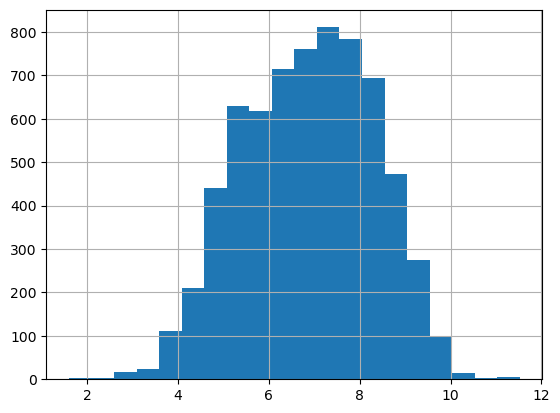

In [20]:
egfr_ligands_data = pd.read_csv(str(DATA / 'EGFR-activities-chembl33-sample.csv'))[
        [
            'activities.standard_type', 
            'molecule_dictionary.chembl_id', 
            'activities.standard_value', 
            'activities.standard_units', 
            'compound_structures.canonical_smiles',
        ]
    ]
egfr_ligands_data = egfr_ligands_data.rename(columns={
    'molecule_dictionary.chembl_id': 'ID',
    'activities.standard_value': 'true_value',
    'activities.standard_units': 'standard_units',
    'compound_structures.canonical_smiles': 'canonical_smiles',
    'activities.standard_type': 'standard_type',
})

egfr_ligands_data = egfr_ligands_data.dropna()
print(f"Drop rows with NaN values to have: {egfr_ligands_data.shape[0]}")
egfr_ligands_data = egfr_ligands_data.drop_duplicates(subset=['canonical_smiles'])
print(f"Drop duplicate smiles to have: {egfr_ligands_data.shape[0]}")

# take only activities with IC50 values
egfr_ligands_data_ic50 = egfr_ligands_data[egfr_ligands_data['standard_type'] == 'pIC50']
print(f"Keep molecules with IC50 only to have: {egfr_ligands_data_ic50.shape[0]}")
egfr_ligands_data_ic50.sort_values(by=['true_value'])
display(egfr_ligands_data_ic50.head())
# stratify molecules by their IC50 values
egfr_ligands_data_ic50['true_value'].hist(bins=20)

### Threshold of 8.00 pIC50 is considered to be active which are the 33.9% of the given data 

In [21]:
# make a column called activity class and assign 1 to active and 0 to inactive with a threshold of 6 for true_vale
egfr_ligands_data_ic50['activity_class'] = egfr_ligands_data_ic50['true_value'].apply(lambda x: 1 if x >= 8 else 0)
display(egfr_ligands_data_ic50.activity_class.value_counts())
egfr_ligands_data_ic50['ROMol'] = egfr_ligands_data_ic50['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))

print(egfr_ligands_data_ic50['activity_class'].value_counts())
# make a random split of the data stratified by the true_value
train, test = train_test_split(egfr_ligands_data_ic50, test_size=0.03, random_state=42, stratify=egfr_ligands_data_ic50['activity_class'])
test['activity_class'].value_counts()

# PandasTools.WriteSDF(
#     test, 
#     str(OUTPUT / 'test_library.sdf'), 
#     idName='chembl_id',
#     molColName='ROMol',
#     properties=list(test.columns),
#     )
# PandasTools.WriteSDF(
#     train, 
#     str(OUTPUT / 'train_library.sdf'),
#     idName='chembl_id', 
#     molColName='ROMol', 
#     properties=list(train.columns)
#     )

/tmp/ipykernel_2220518/2593485849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egfr_ligands_data_ic50['activity_class'] = egfr_ligands_data_ic50['true_value'].apply(lambda x: 1 if x >= 8 else 0)


activity_class
0    4989
1    1698
Name: count, dtype: int64

activity_class
0    4989
1    1698
Name: count, dtype: int64


/tmp/ipykernel_2220518/2593485849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egfr_ligands_data_ic50['ROMol'] = egfr_ligands_data_ic50['canonical_smiles'].apply(lambda x: Chem.MolFromSmiles(x))


activity_class
0    150
1     51
Name: count, dtype: int64

# MolDockLab Workflow

## Prepare ligands library

In [21]:
ligand_library = OUTPUT / 'test_library.sdf'
output_prepared_mols = OUTPUT / f"{ligand_library.stem}_prepared.sdf"
run_gypsumdl(
    ligand_library=ligand_library, 
    prepared_library_path=output_prepared_mols, 
    id_column="chembl_id"
    )

Molecules are already prepared


## Consensus Docking

In [7]:
docking_programs = [
                'GNINA', 
                'SMINA',
                'diffdock', 
                'PLANTS', 
                'flexx',
                ]

n_poses = 10
exhaustiveness = 8

from docking import docking

docking(
        docking_programs,
        protein_file,
        output_prepared_mols,
        ref_file,
        exhaustiveness,
        n_poses,
        OUTPUT,
        local_diffdock=False
        )



Docking with GNINA is running ...

Compounds are already docked with GNINA v 1.0


Docking with SMINA is running ...

Compounds are already docked with SMINA


Docking with DIFFDOCK is running ...

Binding pocket is already extracted


Local DiffDock is running ...:   0%|          | 0/201 [00:00<?, ?it/s]

Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds are already docked with DiffDock
Compounds a

[11:26:32] ERROR: Cannot convert ' C' to int on line 5
[11:26:32] ERROR: moving to the beginning of the next molecule
[11:26:32] ERROR: Cannot convert ' C' to int on line 5
[11:26:32] ERROR: moving to the beginning of the next molecule


ERROR: list index out of range

No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
No poses found for CHEMBL5180325
ERROR: [Errno 20] Not a directory: '/home/ibrahim/Github/ECFT-VS-pipeline/egfr_data/results/diffdock/diffdock_poses.sdf'

No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
No poses found for CHEMBL3633941
ERROR: list index out of range



[11:26:32] ERROR: Cannot convert 'C ' to int on line 5
[11:26:32] ERROR: moving to the beginning of the next molecule


No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL1095464
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL4071170
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses found for CHEMBL3937527
No poses f

### PoseBusters for quality checking

In [7]:
protein_name = 'egfr'
docking_tools_results = poses_checker(
    poses_path= OUTPUT / 'allposes.sdf', 
    protein_path= protein_file, 
    output_file= OUTPUT / f'{protein_name}_posebusters_results.csv'
    )
docking_tools_results

PoseBusters was executed


,docking_tool,internal_steric_clash,double_bond_flatness,internal_energy,protein-ligand_maximum_distance,minimum_distance_to_protein,volume_overlap_with_protein,Number of Docked Molecules
0,diffdock,85,6,115,55,1734,1140,188
1,flexx,13,0,92,0,702,0,199
2,gnina,26,0,138,0,1,0,201
3,plants,56,0,111,0,633,52,193
4,smina,24,0,144,0,10,0,201


## Scoring Functions

In [4]:
rescoring = [
    'cnnscore', 
    'cnnaffinity',  
    'smina_affinity',
    'ad4',  
    'linf9', 
    'rtmscore', 
    'vinardo', 
    'scorch',
    'hyde', 
    'chemplp', 
    'rfscorevs_v1',
    'rfscorevs_v2',
    'rfscorevs_v3', 
    'vina_hydrophobic', 
    'vina_intra_hydrophobic'
    ]
# Load important dataframes

In [7]:
docked_library_path = OUTPUT / f"allposes.sdf"

rescoring_function(
    rescoring,
    protein_file,
    docked_library_path,
    ref_file,
    ncpu=4,
)

protein is already converted to mol2
protein is already converted to pdbqt
protein is already converted to mol2
protein is already converted to pdbqt


Now rescoring with CNNSCORE ... ⌛⌛ 
cnnscore is already excuted
cnnscore is already read


Now rescoring with CNNAFFINITY ... ⌛⌛ 
cnnaffinity is already excuted
cnnaffinity is already read


Now rescoring with SMINA_AFFINITY ... ⌛⌛ 
smina_affinity is already excuted
smina_affinity is already read


Now rescoring with AD4 ... ⌛⌛ 
ad4 is already excuted
ad4 is already read


Now rescoring with LINF9 ... ⌛⌛ 
linf9 is already excuted
linf9 is already read


Now rescoring with RTMSCORE ... ⌛⌛ 
rtmscore is already excuted
rtmscore is already read


Now rescoring with VINARDO ... ⌛⌛ 
vinardo is already excuted
vinardo is already read


Now rescoring with SCORCH ... ⌛⌛ 
scorch is already excuted
scorch is already read


Now rescoring with HYDE ... ⌛⌛ 
hyde is already excuted
hyde is already read


Now rescoring with CHEMPLP ... ⌛⌛ 
chemplp is a

### Scores Normalization

#### Merging true value and splitting

In [5]:

df_rescored_merged = merge_activity_values(
    norm_scored_path = OUTPUT / 'all_rescoring_results.csv', 
    true_value_path = ligand_library,
    true_value_col = 'true_value',
    scored_id_col='ID',
    activity_col='activity_class',
    lower_better_true_value = False,
    threshold=0.9
    )
display(df_rescored_merged)

Scores of {'LinF9', 'ad4', 'rfscore_v3', 'rfscore_v1', 'Vinardo'} were found to highly correlate. Therefore, they are removed


,ID,CNNscore,CNNaffinity,smina_affinity,RTMScore,SCORCH,HYDE,CHEMPLP,rfscore_v2,vina_hydrophobic,vina_intra_hydrophobic,id,docking_tool,true_value,activity_class
0,CHEMBL521155_diffdock_1,0.362049,5.541694,3.66379,10.847826,0.00984,1.084753e+04,-50.2480,7.297412,7.471901,2.000000,CHEMBL521155,diffdock,4.455932,0
1,CHEMBL521155_diffdock_2,0.620789,5.901259,-4.17116,6.298433,0.00647,1.608998e+04,-50.3708,7.423500,7.414102,2.000000,CHEMBL521155,diffdock,4.455932,0
2,CHEMBL521155_diffdock_3,0.406450,5.652869,3.02558,8.625863,0.01061,1.086981e+04,-50.9370,7.293563,4.056627,2.000000,CHEMBL521155,diffdock,4.455932,0
3,CHEMBL521155_diffdock_4,0.619864,6.013198,-3.90986,8.777705,0.00794,4.927514e+06,-58.6264,7.352969,4.799628,2.000000,CHEMBL521155,diffdock,4.455932,0
4,CHEMBL521155_diffdock_5,0.255897,5.596202,4.70408,10.648394,0.00571,2.602023e+03,-43.8082,7.252436,3.143075,2.000000,CHEMBL521155,diffdock,4.455932,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9751,CHEMBL3676363_flexx_06,0.061902,6.602459,-2.09240,13.918188,0.00283,9.413251e+01,179.9840,7.839526,31.332897,7.202832,CHEMBL3676363,flexx,7.721246,0
9752,CHEMBL3676363_flexx_07,0.060686,6.521118,-1.13328,13.708764,0.00414,3.349273e+06,231.2650,7.807870,30.972222,7.202672,CHEMBL3676363,flexx,7.721246,0
9753,CHEMBL3676363_flexx_08,0.028939,6.640325,-3.30266,13.987627,0.00060,1.408263e+06,19.3420,7.945371,26.821023,8.012429,CHEMBL3676363,flexx,7.721246,0
9754,CHEMBL3676363_flexx_09,0.023772,6.654744,-4.00987,13.016237,0.00207,3.074707e+06,69.0963,7.991376,24.239426,7.221183,CHEMBL3676363,flexx,7.721246,0


## Scaffold split for versatility checking 

In [6]:
clustered_df = hdbscan_scaffold_split(ligand_library, min_cluster_size=2)
cv_split(clustered_df, df_rescored_merged, idx_col='ID', n_splits=5, output_path= DATA / 'data_splits', target_name='egfr')

Number of unique scaffolds: 155
Number of HDBSCAN clusters: 24
Train dataset has 104 and test dataset has 97
Train dataset has 175 and test dataset has 26
Train dataset has 175 and test dataset has 26
Train dataset has 174 and test dataset has 27
Train dataset has 176 and test dataset has 25


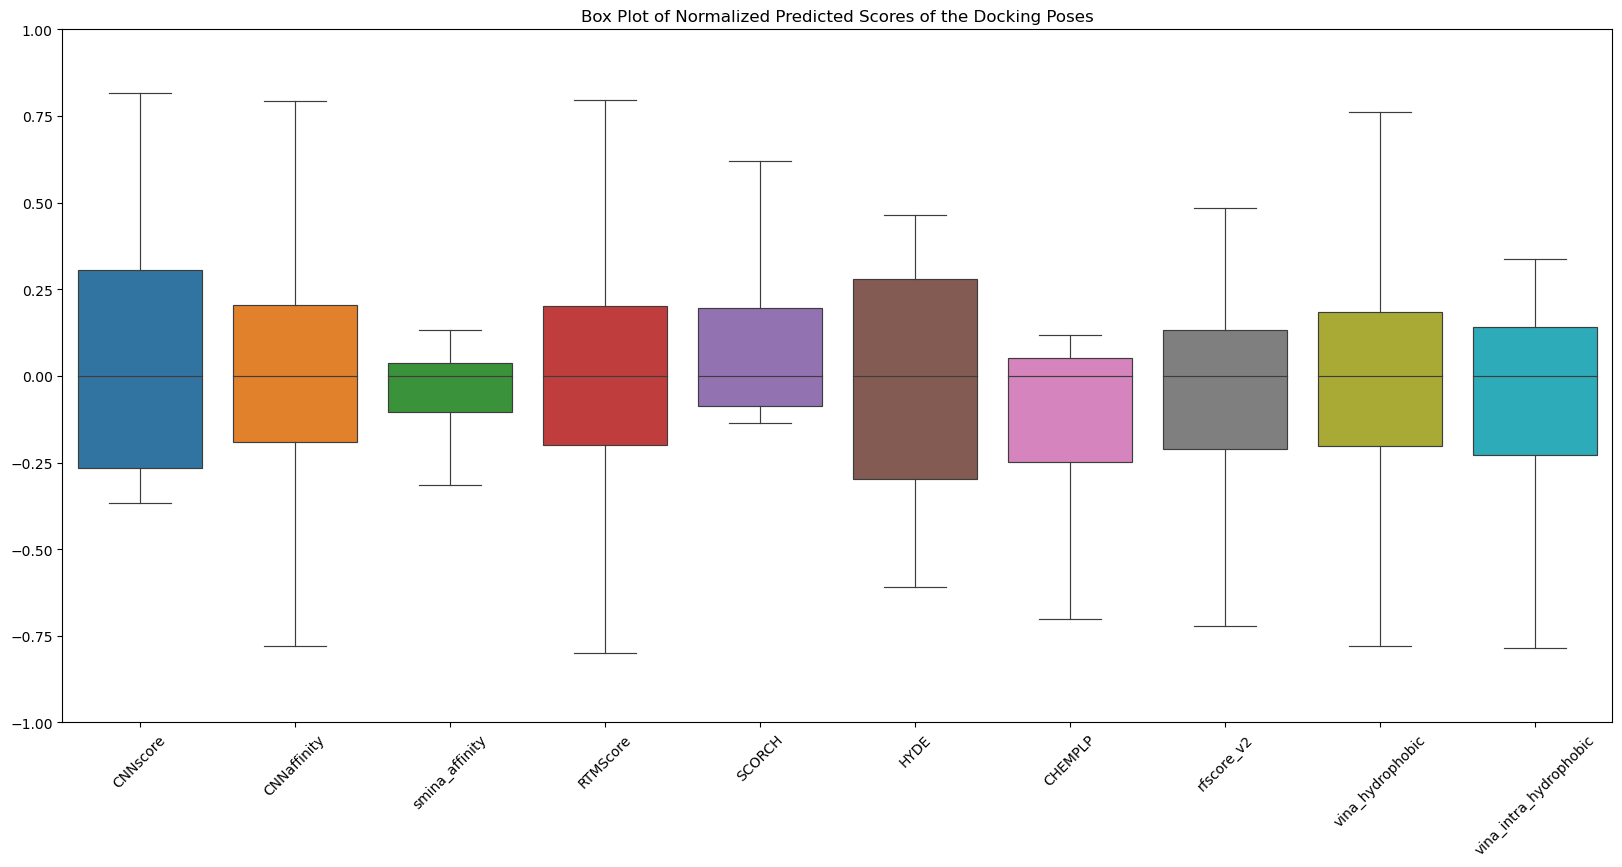

In [7]:
from ranking import norm_scores

norm_scored_path = OUTPUT / 'all_rescoring_results_merged_norm_robust.csv'
df_rescored = pd.read_csv(str(OUTPUT / 'all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored_merged)

plt.figure(figsize=(20, 9))
sns.boxplot(data=df_rescored_norm ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)


## Pose Score Optimization

### Executing optimization function for different regularization

In [9]:
regs = [0, 0.3, 0.5, 0.7, 1, 3, 5, 10, 50]
X, y, docking_cost, scoring_cost, docking_tools, scoring_tools = scores_preprocessing(df_rescored_merged)
best_weights = score_pose_optimization(X, y, docking_cost, scoring_cost, weights_path= DATA / 'best_weights_all_reg_nocoll_abs.pkl.npy', alphas=regs, iter=500)
best_weights

100%|██████████| 9756/9756 [00:01<00:00, 5011.68it/s]


Optimization with Regularization: 0


  0%|          | 0/500 [00:00<?, ?it/s]/home/ibrahim/Github/ECFT-VS-pipeline/pose_score_optimization.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(x)
100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Optimization with Regularization: 0.3


100%|██████████| 500/500 [03:32<00:00,  2.35it/s]


Optimization with Regularization: 0.5


100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


Optimization with Regularization: 0.7


100%|██████████| 500/500 [03:45<00:00,  2.22it/s]


Optimization with Regularization: 1


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


Optimization with Regularization: 3


100%|██████████| 500/500 [04:15<00:00,  1.96it/s]


Optimization with Regularization: 5


100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


Optimization with Regularization: 10


100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Optimization with Regularization: 50


100%|██████████| 500/500 [04:46<00:00,  1.74it/s]


{0: array([ 0.06052566,  0.09143236, -0.21542251,  1.57871441,  0.01284786,
        -0.25091847,  0.03708087,  0.33071441,  0.0028617 , -0.22055987,
         0.3298587 ,  0.03308206, -0.24248488,  0.20802495, -0.00837271]),
 0.3: array([ 8.18024520e-01,  4.42286192e-01,  2.83908644e-01,  4.57133676e-01,
         1.03337705e-01,  1.28012926e-01,  5.63623207e-02,  1.03747907e+00,
         6.74366301e-01,  5.51888579e-01, -1.40733620e-07, -1.70062642e-07,
         3.31679814e-07,  3.30561500e-08,  2.18646070e-07]),
 0.5: array([ 8.53593257e-01,  5.90680583e-01,  8.36588438e-01,  3.60468793e-01,
         9.09087555e-02,  4.71847544e-02,  6.04591626e-01,  2.81339004e-01,
         6.10037369e-01,  8.83671229e-01,  1.43567670e-07, -8.09443031e-08,
        -2.04506221e-07,  8.00482357e-09, -2.25486530e-08]),
 0.7: array([ 4.14652324e-01,  9.06638869e-02, -1.35679090e-01,  7.44045203e-02,
         5.91396152e-02,  5.45365841e-01,  3.13196818e+00,  4.00383292e-02,
         2.64147549e-02,  2.017

### Check the correlation of each alpha with the true value

In [10]:
for alpha in best_weights.keys():
    c_r, c_d = prepare_parameters(best_weights[alpha])
    preds = pd.DataFrame({'prediction': prediction(c_r, c_d, X), 'ground truth': y})
    corr = preds.corr('spearman')['ground truth']['prediction']
    # sns.lmplot(data=preds, x='prediction', y='ground truth')
    print(f"Using alpha {alpha} give a correlation of : {corr}")

Using alpha 0 give a correlation of : 0.5139981373290207
Using alpha 0.3 give a correlation of : 0.16473760260623033
Using alpha 0.5 give a correlation of : -0.2154648023251184
Using alpha 0.7 give a correlation of : 0.011619826413692535
Using alpha 1 give a correlation of : -0.03301372530610343
Using alpha 3 give a correlation of : 0.1766869751588334
Using alpha 5 give a correlation of : -0.15232198876741082
Using alpha 10 give a correlation of : 0.17238514192848123
Using alpha 50 give a correlation of : 0.0435015681215652


### Mapping the normalized weights to docking tools and scoring functions

In [12]:
selected_docking = {}
selected_rescoring = {}
for alpha in best_weights.keys():
    normalized_weights = mapping_normalized_weights(best_weights[alpha], scoring_tools, docking_tools)
    print(f"Using alpha {alpha} give normalized weights: \n{normalized_weights}\n")
    #extract the tools that is above 0.5 in a list
    selected_docking[alpha] = [key for key, value in list(normalized_weights.items())[:5] if value > 0.5]
    selected_rescoring[alpha] = [key for key, value in list(normalized_weights.items())[6:] if value > 0.5]
    print(f"Using alpha {alpha} give selected tools: \n For Docking:{selected_docking[alpha]}\n For Rescoring:{selected_rescoring[alpha]}\n")

Using alpha 0 give normalized weights: 
{'diffdock': 1.0, 'plants': 0.4814711755597849, 'gnina': 0.0, 'smina': 0.7871317979060262, 'flexx': 0.4090413057769987, 'CNNscore': 0.17022219862992502, 'CNNaffinity': 0.18711449582681922, 'smina_affinity': 0.019400590273120803, 'RTMScore': 1.0, 'SCORCH': 0.14416352490129639, 'HYDE': 0.0, 'CHEMPLP': 0.1574082658069239, 'rfscore_v2': 0.31789594758864076, 'vina_hydrophobic': 0.13870551487660682, 'vina_intra_hydrophobic': 0.016592725405048945}

Using alpha 0 give selected tools: 
['diffdock', 'smina']
['RTMScore']

Using alpha 0.3 give normalized weights: 
{'diffdock': 0.05845433708158765, 'plants': 0.0, 'gnina': 1.0, 'smina': 0.40482679854786935, 'flexx': 0.7747176007617753, 'CNNscore': 0.7763216743386354, 'CNNaffinity': 0.39335162783000477, 'smina_affinity': 0.23192583682172088, 'RTMScore': 0.40848487663885635, 'SCORCH': 0.04787950533351667, 'HYDE': 0.07302964187648502, 'CHEMPLP': 0.0, 'rfscore_v2': 1.0, 'vina_hydrophobic': 0.6298985107391317, 'vi

## Consensus Ranking

In [9]:
ranking_methods = [
                'best_ECR' ,
                'ECR_average',
                'average_ECR' ,
                'rank_by_rank' ,
                'rank_by_vote' ,
                'rank_by_name',
                'best_Zscore',
                'average_Zscore',
                'weighted_ECR'
                ]

In [ ]:
from ranking import *
poses_ranking(
    ranking_methods,
    df_rescored_norm,
    OUTPUT,
    weights=normalized_weights,
    ncpus=7,
)

Number of docking programs: 5, ['plants', 'flexx', 'smina', 'localdiffdock', 'gnina']
Number of rescoring methods: 15, ['CNNscore', 'CNNaffinity', 'smina_affinity', 'ad4', 'LinF9', 'RTMScore', 'Vinardo', 'SCORCH', 'HYDE', 'CHEMPLP', 'rfscore_v1', 'rfscore_v2', 'rfscore_v3', 'vina_hydrophobic', 'vina_intra_hydrophobic']
Number of possible combinations for every ranking method: 1015777
 With total combinations : 1015777
Parallelizing weighted_ECR...


  0%|          | 812/1015777 [00:14<5:14:19, 53.82it/s]

KeyboardInterrupt: 

  0%|          | 1181/1015777 [00:21<5:35:48, 50.36it/s]

### Mapping the Pose Score Optimization to consensus ranking

In [14]:
corr_df = pd.read_csv(DATA / 'results/egfr_general/correlations_general/all_ranked.csv')
corr_df

,docking_tool,scoring_function,spearman_correlation,cost_per_pipeline,enrichment_factor,ranking_method
0,['diffdock'],['RTMScore'],0.494129,411.60,1.940144,method8_RbN
1,['diffdock'],['RTMScore'],0.494129,411.60,1.940144,method5_RbV
2,['diffdock'],['RTMScore'],0.494129,411.60,1.940144,method4_RbR
3,['diffdock'],['RTMScore'],0.491912,411.60,1.940144,method7_Zscore_avg
4,['diffdock'],['RTMScore'],0.491912,411.60,1.940144,method3_avg_ECR
...,...,...,...,...,...,...
285412,"['flexx', 'smina']","['CHEMPLP', 'CNNscore', 'HYDE', 'smina_affinit...",-0.259533,137.54,0.758491,method3_avg_ECR
285413,"['flexx', 'gnina', 'smina']","['CNNscore', 'HYDE', 'smina_affinity', 'vina_i...",-0.262705,242.13,0.758491,method3_avg_ECR
285414,['plants'],"['CNNscore', 'SCORCH', 'vina_intra_hydrophobic']",-0.263501,63.12,0.586032,method3_avg_ECR
285415,['plants'],"['CNNscore', 'SCORCH', 'vina_intra_hydrophobic']",-0.266745,63.12,0.390688,method2_ECR_average


In [15]:
# make docking_tool and scoring_tool columns as lists
corr_df = pd.read_csv(DATA / 'results/egfr_general/correlations_general/all_ranked.csv').dropna()
corr_df['docking_tool'] = corr_df['docking_tool'].apply(lambda x: ast.literal_eval(x))
corr_df['scoring_function'] = corr_df['scoring_function'].apply(lambda x: ast.literal_eval(x))

# Implementation of Larger Data

In [9]:
chembl_data = PandasTools.LoadSDF(str(DATA / 'train_library.sdf'))
chembl_data.head()

## Ligands preparation

In [5]:
OUTPUT = DATA / "chembl_results"
OUTPUT.mkdir(exist_ok=True)

chembl_library = str(OUTPUT / 'train_library.sdf')
prepared_chembl_data_path = OUTPUT / f"chembl_data_prepared.sdf"
run_gypsumdl(str(chembl_library), prepared_chembl_data_path)

Molecules are already prepared


## Molecular Docking of selected tools

In [50]:
from docking import docking

selected_docking_programs = [
    'diffdock',
    ]
docking(
        selected_docking_programs,
        protein_file,
        prepared_chembl_data_path,
        ref_file,
        64,
        10,
        OUTPUT
        )



Docking with FLEXX is running ...

Reference ligand is already in SDF format


: 

: 

## Interaction hotspots detection using PLIPify

In [4]:
from src.interaction_analysis import (
    split_sdf_path, 
    actives_extraction, 
    plipify_ligand_protein_interaction, 
    indiviudal_interaction_fp_generator, 
    read_interactions_json, 
    interactions_aggregation
)

from src.ranking import norm_scores, enrichment_factor_calc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

actives_path = actives_extraction( 
    DATA / 'results/allposes.sdf', 
    DATA / 'results/all_rescoring_results_merged.csv', 
    docking_tool='diffdock'
    )

ligands_paths = split_sdf_path(actives_path)

Number of active compounds: 510


SDF splitting:   0%|          | 0/510 [00:00<?, ?it/s]

Fingerprint Interactions are already saved in /home/ibrahim/Github/ECFT-VS-pipeline/egfr_data/results/egfr_interactions_X.png


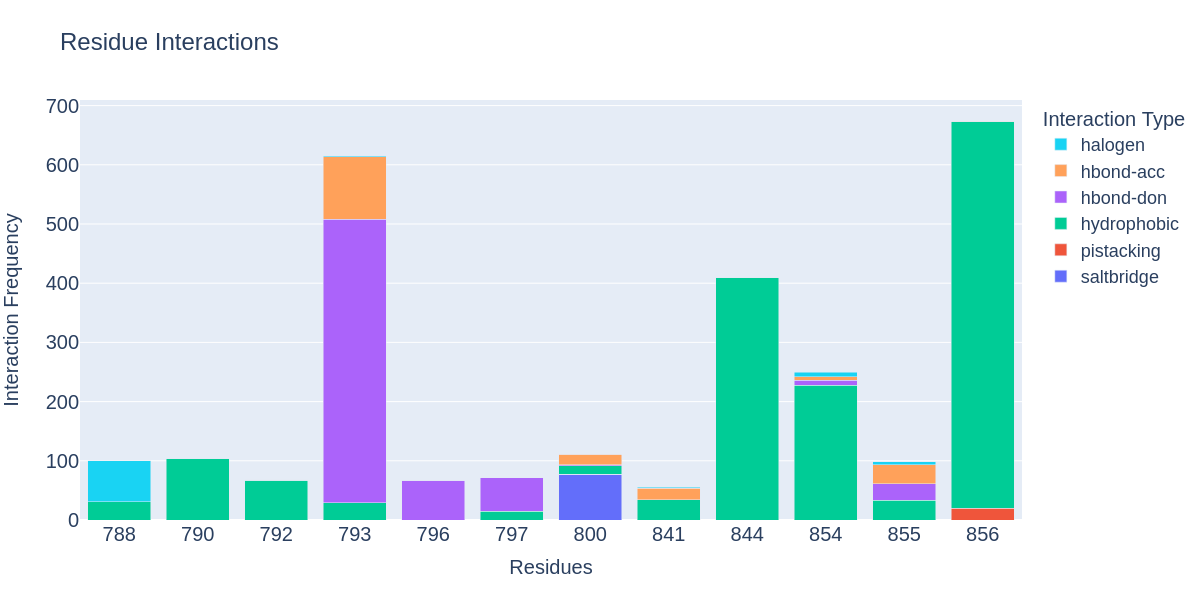

: 

In [6]:
output_file=OUTPUT / 'egfr_interactions_X.png'
fp_focused = plipify_ligand_protein_interaction(
    ligands_path = ligands_paths, 
    protein_path=protein_file, 
    protein_name='EGFR', 
    chains='X',
    output_file=output_file
    )
display(Image(filename=output_file))

## Interaction fingerprints generations

In [9]:
included_chains = ['X']
protein_name = 'egfr'

allposes_interaction_fp = indiviudal_interaction_fp_generator(ligands_paths, 
                                                              protein_file, 
                                                              protein_name, 
                                                              included_chains, 
                                                              OUTPUT / 'fp_allposes.json')

Interactions for all poses are already executed


In [12]:
interactions_df = read_interactions_json(
    json_file=OUTPUT / 'fp_allposes_chembl_diffdock.json', 
    output_file=OUTPUT / 'allposes_interaction_fps_final.csv'
    )
        
interactions_df  

Interactions are converted to CSV file.


,Poses,707X,741X,742X,743X,744X,752X,753X,754X,758X,...,879X,880X,903X,904X,905X,906X,907X,913X,914X,961X
0,CHEMBL101253_diffdock_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL101253_diffdock_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL101253_diffdock_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL101253_diffdock_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL101253_diffdock_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57690,CHEMBL99024_diffdock_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57691,CHEMBL99024_diffdock_6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57692,CHEMBL99024_diffdock_7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57693,CHEMBL99024_diffdock_8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
agg_interx_df = interactions_aggregation(
                     interactions_df=interactions_df.reset_index(),
                     important_interactions=['793X', '844X', '854X', '856X'],
                     id_column='Poses'
)
agg_interx_df.replace(0, np.nan, inplace=True)

# Drop rows with any NaN values
agg_interx_df.dropna(inplace=True)
agg_interx_df

,id,793X,844X,854X,856X
0,CHEMBL101253,6.0,6.0,4.0,8.0
1,CHEMBL1016,8.0,9.0,7.0,8.0
2,CHEMBL101683,3.0,7.0,2.0,7.0
3,CHEMBL102726,10.0,8.0,1.0,5.0
4,CHEMBL103552,10.0,9.0,4.0,7.0
...,...,...,...,...,...
5986,CHEMBL96627,9.0,3.0,4.0,9.0
5987,CHEMBL96780,9.0,4.0,6.0,9.0
5988,CHEMBL97162,8.0,10.0,5.0,10.0
5989,CHEMBL98798,10.0,4.0,9.0,9.0


## Selected Scoring functions 

In [32]:
docked_library_path = OUTPUT / f"allposes.sdf"
selected_rescoring = [
    # 'cnnscore', 
    # 'cnnaffinity',  
    # 'smina_affinity', 
    # 'ad4',
    # 'hyde',
    # 'linf9', 
    # 'rtmscore', 
    'vinardo',
    # 'scorch',
    # 'chemplp',
    # 'rfscorevs_v1',
    'rfscorevs_v2',  
    # 'rfscorevs_v3', 
    # 'vina_hydrophobic', 
    # 'vina_intra_hydrophobic',
    ]

# Load important dataframes

rescoring_function(
    selected_rescoring,
    protein_file,
    docked_library_path,
    ref_file,
    ncpu=7,
)



Now rescoring with VINARDO ... ⌛⌛ 
vinardo is already excuted
vinardo is already read


Now rescoring with RFSCOREVS_V2 ... ⌛⌛ 
rfscorevs_v2 is already excuted
rfscorevs_v2 is already read


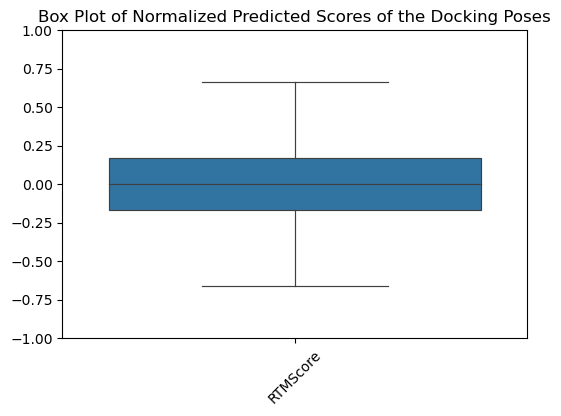

In [7]:
norm_scored_path = OUTPUT / 'best_correlation/all_rescoring_results_norm_robust.csv'
df_rescored = pd.read_csv(str(OUTPUT / 'best_correlation/all_rescoring_results.csv'))

df_rescored_norm = norm_scores(df_rescored)

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_rescored_norm ,linewidth=.85, showfliers=False)
plt.ylim(-1, 1)
plt.title('Box Plot of Normalized Predicted Scores of the Docking Poses')
plt.xticks(rotation=45) 
plt.show()

df_rescored_norm.to_csv(str(norm_scored_path), index=False)

In [10]:
rescored_library = pd.read_csv(str(norm_scored_path))
rescored_library['id'] = rescored_library.ID.str.split('_').str[0]

## Selected Ranking Method

In [11]:
from src.ranking import RbV

ranked_scores = RbV(
    rescored_library,
    weight=0.5, 
    selected_columns=[
        'RTMScore',
        # 'vinardo',
        # 'rfscorevs_v2'
        ],
    id_column='id'
    ).sort_values(by=['RbV'], ascending=False)

ranked_scores

,id,RbV
2837,CHEMBL3699591,5990.0
5176,CHEMBL5094480,5989.0
5236,CHEMBL5172251,5988.0
5127,CHEMBL5078413,5985.0
2609,CHEMBL3639984,5985.0
...,...,...
784,CHEMBL1828872,3.0
1831,CHEMBL307145,3.0
1761,CHEMBL290106,2.0
5897,CHEMBL77381,1.0


In [12]:
egfr_ligands_data = pd.read_csv(str(DATA / 'EGFR-activities-chembl33-sample.csv'))[
        [
            'activities.standard_type', 
            'molecule_dictionary.chembl_id', 
            'activities.standard_value', 
            'activities.standard_units', 
            'compound_structures.canonical_smiles',
        ]
    ]
egfr_ligands_data = egfr_ligands_data.rename(columns={
    'molecule_dictionary.chembl_id': 'id',
    'activities.standard_value': 'true_value',
    'activities.standard_units': 'standard_units',
    'compound_structures.canonical_smiles': 'canonical_smiles',
    'activities.standard_type': 'standard_type',
}).drop_duplicates(subset='id')
egfr_ligands_data['activity_class'] = egfr_ligands_data['true_value'].apply(lambda x: 1 if x >= 8 else 0)

true_value_df = ranked_scores.merge(egfr_ligands_data, on='id')
true_value_df.drop_duplicates()

,id,RbV,standard_type,true_value,standard_units,canonical_smiles,activity_class
0,CHEMBL3699591,5990.0,pIC50,7.187087,nM,C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(N4CCOCC4)cc3OC(F)...,0
1,CHEMBL5094480,5989.0,pIC50,9.045757,nM,COc1cc(N2CCC(N(C)C)CC2)c(-c2cn[nH]c2)cc1Nc1ncc...,1
2,CHEMBL5172251,5988.0,pIC50,8.200659,nM,CCc1cc(Nc2ncc(Cl)c(-c3cn(S(=O)(=O)CC)c4ccccc34...,1
3,CHEMBL5078413,5985.0,pIC50,8.619789,nM,CCP(=O)(CC)c1ccccc1Nc1nc(Nc2cc(-c3cnn(C)c3)c(N...,1
4,CHEMBL3639984,5985.0,pIC50,7.187087,nM,C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(N4CCN(C(=O)CO)CC4...,0
...,...,...,...,...,...,...,...
5986,CHEMBL1828872,3.0,pIC50,5.018181,nM,O=C(Cc1ccc(Cl)cc1)NS(=O)(=O)c1ccc(F)cc1,0
5987,CHEMBL307145,3.0,pIC50,5.910095,nM,Oc1cccc(O)c1O,0
5988,CHEMBL290106,2.0,pIC50,6.211832,nM,Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O,0
5989,CHEMBL77381,1.0,pIC50,2.866461,nM,N#C/C(=C/c1ccc[nH]1)C(=O)O,0


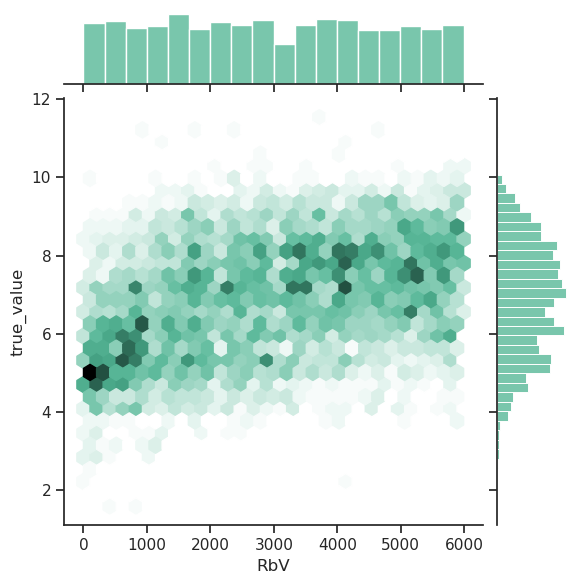

In [59]:
import numpy as np
import seaborn as sns

sns.set_theme(style="ticks")


sns.jointplot(x=true_value_df.RbV, y=true_value_df.true_value, kind="hex", color="#4CB391")

## Correlation Pipeline

In [26]:
spearman_corr, _ = spearmanr(true_value_df.RbV, true_value_df.true_value)
ef_1 = enrichment_factor_calc(true_value_df, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.4048759942194363
Enrichment factor for 1% is 189.01109660574411%
Enrichment factor for 3% is 191.18363794604%
Enrichment factor for 5% is 175.97584856396867%
Enrichment factor for 10% is 154.72556523710097%


## EF pipeline

In [19]:
spearman_corr, _ = spearmanr(true_value_df.method8_RbN, true_value_df.true_value)
ef_1 = enrichment_factor_calc(true_value_df, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.2733267484113711
Enrichment factor for 1% is 127.22138836772984%
Enrichment factor for 3% is 121.78777973346743%
Enrichment factor for 5% is 114.59865589367968%
Enrichment factor for 10% is 120.08476176093032%


## Scoring by filtering key interactions

In [32]:
interactions_scores_merged = ranked_scores.merge(agg_interx_df, on='id')
interactions_scores_merged

,id,RbV,842X,844X,844X,856X
0,CHEMBL5172251,5988.0,1.0,8.0,8.0,8.0
1,CHEMBL5078413,5985.0,1.0,6.0,6.0,10.0
2,CHEMBL5081299,5985.0,1.0,5.0,5.0,8.0
3,CHEMBL5087264,5982.0,1.0,6.0,6.0,7.0
4,CHEMBL5174418,5981.0,2.0,7.0,7.0,7.0
...,...,...,...,...,...,...
802,CHEMBL2325102,22.0,1.0,9.0,9.0,5.0
803,CHEMBL1173813,14.0,1.0,8.0,8.0,6.0
804,CHEMBL1172573,14.0,1.0,8.0,8.0,6.0
805,CHEMBL4640482,9.0,1.0,9.0,9.0,9.0


In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

interactions_scores_merged = ranked_scores.merge(agg_interx_df, on='id')
features = interactions_scores_merged.columns[1:]
interactions_scores_merged[features] = interactions_scores_merged[features].apply(pd.to_numeric, errors='coerce')
display(interactions_scores_merged)
scaler = MinMaxScaler()
interactions_scores_merged[features] = scaler.fit_transform(interactions_scores_merged[features])
interactions_scores_merged['all_scores'] = interactions_scores_merged[features].sum(axis=1)
true_value_df_interactions = interactions_scores_merged.merge(egfr_ligands_data, on='id')
true_value_df_interactions.activity_class.value_counts()

,id,RbV,793X,844X,854X,856X
0,CHEMBL3699591,5990.0,10.0,9.0,3.0,9.0
1,CHEMBL5094480,5989.0,10.0,7.0,8.0,5.0
2,CHEMBL5172251,5988.0,10.0,8.0,4.0,8.0
3,CHEMBL5078413,5985.0,10.0,6.0,6.0,10.0
4,CHEMBL3639984,5985.0,10.0,8.0,1.0,10.0
...,...,...,...,...,...,...
5479,CHEMBL1173248,8.0,1.0,8.0,2.0,7.0
5480,CHEMBL1173250,6.0,1.0,8.0,2.0,9.0
5481,CHEMBL1822064,3.0,4.0,8.0,3.0,5.0
5482,CHEMBL1828872,3.0,1.0,8.0,4.0,6.0


activity_class
0    4069
1    1415
Name: count, dtype: int64

In [52]:
spearman_corr, _ = spearmanr(true_value_df_interactions.RbV, true_value_df_interactions.true_value)
ef_1 = enrichment_factor_calc(true_value_df_interactions, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df_interactions, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df_interactions, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df_interactions, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.401095872845267
Enrichment factor for 1% is 190.25762929649855%
Enrichment factor for 3% is 197.30420815933178%
Enrichment factor for 5% is 173.97848907688734%
Enrichment factor for 10% is 157.71220757782876%


In [58]:
true_value_df_interactions.sort_values(by='RbV', ascending=False,inplace=True)
spearman_corr, _ = spearmanr(true_value_df_interactions.all_scores, true_value_df_interactions.true_value)
ef_1 = enrichment_factor_calc(true_value_df_interactions, percent=1, activity_class='activity_class')
ef_3 = enrichment_factor_calc(true_value_df_interactions, percent=3, activity_class='activity_class')
ef_5 = enrichment_factor_calc(true_value_df_interactions, percent=5, activity_class='activity_class')
ef_10 = enrichment_factor_calc(true_value_df_interactions, percent=10, activity_class='activity_class')

print(f"Spearman correlation of the train data is {spearman_corr}")
print(f"Enrichment factor for 1% is {ef_1*100}%")
print(f"Enrichment factor for 3% is {ef_3*100}%")
print(f"Enrichment factor for 5% is {ef_5*100}%")
print(f"Enrichment factor for 10% is {ef_10*100}%")

Spearman correlation of the train data is 0.3228106305848993
Enrichment factor for 1% is 197.30420815933178%
Enrichment factor for 3% is 194.9553485383874%
Enrichment factor for 5% is 175.39294833767505%
Enrichment factor for 10% is 157.71220757782876%
